In [68]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from pathlib import Path
from pprint import pprint
from scipy.io import loadmat
from tqdm import trange, tqdm
from scipy.stats import ttest_ind
from collections import defaultdict as ddict
from easydict import EasyDict as edict
from functools import partial

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.cluster import KMeans, SpectralClustering

# import holoviews as hv
# from holoviews import opts, dim

%matplotlib inline

In [2]:
# import my own functions
import sys
sys.path.append("../../mypkg")
import importlib

# paras
import paras
importlib.reload(paras);
from paras import paras

# some useful constants
import constants
importlib.reload(constants)
from constants import REGION_NAMES, REGION_NAMES_WLOBE, RES_ROOT, DATA_ROOT

In [18]:
# utils
import utils.matrix
importlib.reload(utils.matrix)
from utils.matrix import eig_sorted

import utils.misc
importlib.reload(utils.misc)
from utils.misc import paras2name, cumsum_cutoff, save_pkl_dict2folder, load_pkl_folder2dict

import utils.standardize
importlib.reload(utils.standardize)
from utils.standardize import minmax, minmax_mat, minmax_pn, minmax_plotting

import utils.brain_plot
importlib.reload(utils.brain_plot)
from utils.brain_plot import reorder_U, U_2brain_vec

## Some fns

In [4]:
def _get_sig_val_trans_curve(ecpts, sig_val):
    ecpts_full = np.concatenate([[0], ecpts, [7200]])
    sig_val_trans_vec = np.zeros(7200)
    for ix in range(len(ecpts_full)-1):
        low_idx, up_idx = ecpts_full[ix:(ix+2)].astype(int)
        sig_val_trans_vec[low_idx:up_idx] = sig_val[ix]
    return sig_val_trans_vec

In [5]:
def _cpts_2dwells(cpts, bds=[0, 7200], fs=120):
    cpts_full = np.sort(np.concatenate([bds, cpts]))
    return np.diff(cpts_full)/fs

In [6]:
# update the count transited from one state to another. 
def _update_trans_ct(cur_trans_ct, vec):
    for ix in range(len(vec)-1):
        from_ = vec[ix]
        to_ = vec[ix+1]
        cur_trans_ct[from_, to_] += 1
    return cur_trans_ct

In [7]:
# plot the corrmat with 7 canonical nets
def _corr_plot(vecs, cutoff=0.05, trun_fn=lambda x:x, trans_fn=np.abs):
    vecs = np.array(vecs)
    if vecs.shape[0] != 68:
        vecs = vecs.T
    assert vecs.shape[0] == 68
    corrMat = np.zeros((7, vecs.shape[-1]))
    for ix in range(vecs.shape[-1]):
        curU = vecs[:, ix]
        curU = trun_fn(curU)
        for iy, kz in enumerate(_paras.canon_net_names):
            curV = _paras.canon_nets[kz]
            curV = trun_fn(curV)
            corr_v, pv = scipy.stats.pearsonr(curU, curV)
            if pv <= cutoff:
                corrMat[iy, ix] = corr_v
            else:
                corrMat[iy, ix] = 0
            
    plt.figure(figsize=[15, 5])
    trans_corrMat = trans_fn(corrMat)
    sns.heatmap(trans_corrMat,  yticklabels=_paras.canon_net_names, 
                cmap="coolwarm", center=0, 
                vmin=-1, vmax=1, annot=np.round(trans_corrMat, 2))
    return corrMat

In [8]:
# truncate small value in vec
def _cumsum_trunc(vec, cutoff=0.9):
    vec = vec.copy()
    idxs = cumsum_cutoff(vec, cutoff)
    counter_idxs = np.delete(np.arange(len(vec)), idxs)
    vec[counter_idxs] = 0
    return vec

In [85]:
def _minmax_wo0(vec):
    """minmax vec without consider the 0s in the vec
    """
    vec_trans = np.zeros_like(vec)
    vec_trans[vec!=0] = minmax_plotting(vec[vec!=0])
    return vec_trans

# save the files for brainplotting
def _save_brainplotting_vec(vecs, filname_prefix, is_csv=False, trans_fn=_minmax_wo0):
    vecs = np.array(vecs)
    if vecs.shape[0] != 68:
        vecs = vecs.T
    for ix in range(vecs.shape[1]):
        cur_sing_vec = vecs[:, ix]
        out_vec_raw = trans_fn(cur_sing_vec)
        out_vec = U_2brain_vec(reorder_U(out_vec_raw))
        np.savetxt(_paras.save_dir/f"./{filname_prefix}_{ix+1}.txt", out_vec)
        if is_csv:
            pd.DataFrame({"Name": REGION_NAMES,
                      "Vec": cur_sing_vec}).to_csv(_paras.save_dir/f"./{filname_prefix}_{ix+1}.csv",
                                                          index=False)

## Parameters

In [10]:
pprint(paras)

{'Cs': array([1.0e+02, 2.5e+01, 1.0e+01, 5.0e+00, 2.0e+00, 1.0e+00, 5.0e-01,
       2.0e-01, 1.0e-01, 5.0e-02, 1.0e-02]),
 'L': 100.0,
 'Lmin': 200,
 'T': 2,
 'cur_dir': PosixPath('/data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg'),
 'cutoff': 0.6,
 'data_dir': PosixPath('../data'),
 'decimate_rate': 5,
 'downsample_rate': 20,
 'fct': 0.5,
 'fig_dir': PosixPath('../figs'),
 'is_detrend': True,
 'kappa': 3.21,
 'kps': array([1.        , 1.003003  , 1.00600601, 1.00900901, 1.01201201,
       1.01501502, 1.01801802, 1.02102102, 1.02402402, 1.02702703,
       1.03003003, 1.03303303, 1.03603604, 1.03903904, 1.04204204,
       1.04504505, 1.04804805, 1.05105105, 1.05405405, 1.05705706,
       1.06006006, 1.06306306, 1.06606607, 1.06906907, 1.07207207,
       1.07507508, 1.07807808, 1.08108108, 1.08408408, 1.08708709,
       1.09009009, 1.09309309, 1.0960961 , 1.0990991 , 1.1021021 ,
       1.10510511, 1.10810811, 1.11111111, 1.11411411, 1.11711712,
       1.12012012

In [11]:
# this parameters only for this file
_paras = edict()
_paras.folder_name = "method3"
_paras.save_dir = RES_ROOT/_paras.folder_name
print(f"Save to {_paras.save_dir}")

Save to /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3


In [12]:
# Lets save some results
post_paras = edict()

##  Load data

In [13]:
cur_res = load_pkl_folder2dict(_paras.save_dir)

Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/dXXmats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/Amats_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_ctrl.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/CPDresult_AD.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/can_pts_ctrls.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/gTVDN/notebooks/method3/../../mypkg/../results/method3/can_pts_ADs.pkl
Load file /data/rajlab1/user_data/jin/

In [72]:
defNetsFil = list(DATA_ROOT.glob("DK_dic68.csv"))[0]
defNets = pd.read_csv(defNetsFil).T

DefNets_dict = {}
for ix in range(defNets.shape[-1]):
    curCol = defNets[ix]
    DefNets_dict[curCol[0]] = np.array(curCol[1:])
net_names = sorted(DefNets_dict.keys())

_paras.canon_nets = DefNets_dict
_paras.canon_net_names = net_names

## singular value (weights) analysis (Not good)

In [13]:
# note that I take abs of B3 for both grps
abs_B3_AD = np.abs(CPDresult_AD[-1])
abs_B3_ctrl = np.abs(CPDresult_ctrl[-1])
abs_B3_both = np.concatenate([abs_B3_AD, abs_B3_ctrl], axis=0)

In [14]:
# fit PCAs for AD and ctrl grps
pca_fit_AD = PCA(n_components=2)
pca_fit_AD.fit(abs_B3_AD)
pca_fit_ctrl = PCA(n_components=2)
pca_fit_ctrl.fit(abs_B3_ctrl)

pca_fit_both = PCA(n_components=2)
pca_fit_both.fit(abs_B3_both)

PCA(n_components=2)

In [15]:
# reduce the dim
singular_vals_ADs_red = [pca_fit_both.transform(np.abs(singular_vals_ADs[ix].T)) for ix in range(88)]
singular_vals_ctrls_red = [pca_fit_both.transform(np.abs(singular_vals_ctrls[ix].T)) for ix in range(88)]

In [16]:
sig_val_curves_AD = []
for ix in range(88):
    cur_curve = get_sig_val_trans_curve(cpts_ADs_selected[ix], 
                                        np.median(np.abs(singular_vals_ADs[ix]), axis=0))
    #cur_curve = get_sig_val_trans_curve(cpts_ADs_selected[ix], singular_vals_ADs_red[ix][:, 0])
    sig_val_curves_AD.append(cur_curve)
    
sig_val_curves_ctrl = []
for ix in range(88):
    cur_curve = get_sig_val_trans_curve(cpts_ctrls_selected[ix], 
                                        np.median(np.abs(singular_vals_ctrls[ix]), axis=0))
    #cur_curve = get_sig_val_trans_curve(cpts_ctrls_selected[ix], singular_vals_ctrls_red[ix][:, 0])
    sig_val_curves_ctrl.append(cur_curve)
    
sig_val_curves_AD = np.array(sig_val_curves_AD)
sig_val_curves_ctrl = np.array(sig_val_curves_ctrl)

In [17]:
center_vec = lambda x: x-x.mean()
plt_AD_vec = center_vec(np.median(sig_val_curves_AD, axis=0))
plt_ctrl_vec = center_vec(np.median(sig_val_curves_ctrl, axis=0))

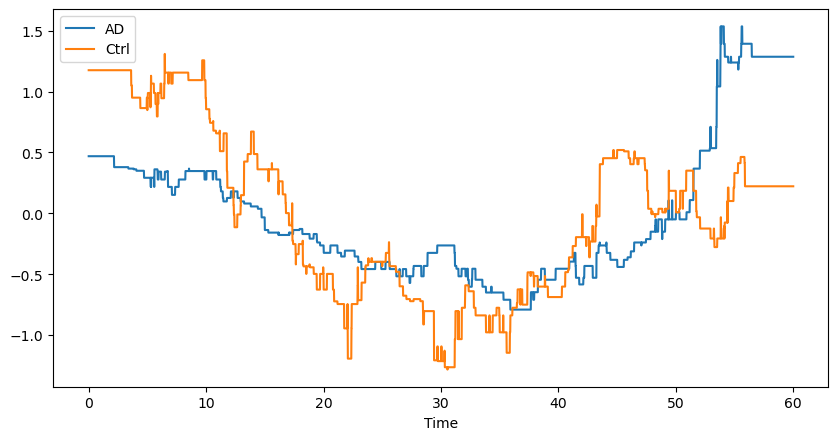

In [18]:
plt.figure(figsize=[10, 5], dpi=100)
times = np.linspace(0, 60, 7200)
plt.plot(times, plt_AD_vec, "-", label="AD")
plt.plot(times, plt_ctrl_vec, "-", label="Ctrl")
plt.xlabel("Time")
plt.legend()

## U analysis

20 is too many to have good results

### Save U for brain plot

In [39]:
# 20 is too many to have good results
_save_brainplotting_vec(cur_res.CPDresult_ctrl[0], "B1", False)
_save_brainplotting_vec(np.abs(cur_res.CPDresult_ctrl[0]), "absB1")

## wU analysis

In [58]:
# put all the singular values together
# always abs singluar vals
singular_vals_ADs_pool = np.abs(np.concatenate(cur_res.singular_vals_ADs, axis=1))
singular_vals_ctrls_pool = np.abs(np.concatenate(cur_res.singular_vals_ctrls, axis=1))
singular_vals_both_pool = np.abs(np.concatenate([singular_vals_ADs_pool, singular_vals_ctrls_pool], axis=1))

In [59]:
# if not minmax, the clustering is poor
singular_vals_both_pool_mm = minmax_mat(singular_vals_both_pool, is_row=False)
singular_vals_ctrls_pool_mm = minmax_mat(singular_vals_ctrls_pool, is_row=False)
singular_vals_ADs_pool_mm = minmax_mat(singular_vals_ADs_pool, is_row=False)

In [200]:
singular_vals_both_pool_mm = singular_vals_both_pool/np.linalg.norm(singular_vals_both_pool,axis=0)
singular_vals_ctrls_pool_mm = singular_vals_ctrls_pool/np.linalg.norm(singular_vals_ctrls_pool,axis=0)
singular_vals_ADs_pool_mm = singular_vals_ADs_pool/np.linalg.norm(singular_vals_ADs_pool,axis=0)

###  Clustering singular values (Only Ctrl)

In [107]:
# find the best num of clusters
def kmeans_BIC(kmCluObj, Cn=1):
    nclu = kmCluObj.n_clusters
    nsps = len(kmCluObj.labels_)
    nDim = kmCluObj.cluster_centers_.shape[1]
    log_lik = np.log(kmCluObj.inertia_/nsps/nDim)
    BIC = log_lik + Cn*np.log(np.log(nsps*nDim))*np.log(nsps)*(nclu-1)/nsps
    #BIC = nsps*log_lik + np.log(nsps)*nclu*nDim/2
    #BIC = nsps*log_lik/(nsps-nDim*nclu)
    #BIC = nsps*log_lik + nclu*nDim
    return BIC

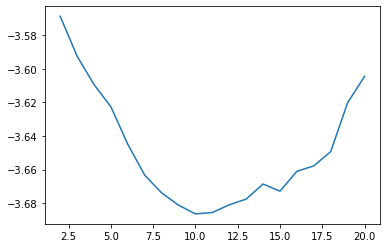

In [108]:
# tuning num of clus (not used)
n_cluss = np.array(list(range(2,21)))
BICs =[]
stds = []
for ix in n_cluss:
    cur_clus = KMeans(n_clusters=ix, random_state=0).fit(singular_vals_ctrls_pool_mm.T)
    BICs.append(kmeans_BIC(cur_clus, 2))
    stds.append(np.std(np.unique(cur_clus.labels_, return_counts=True)[1]))
plt.plot(n_cluss, BICs)

In [319]:
n_clus = 7
#clus = SpectralClustering(n_clusters=n_clus, random_state=0).fit(singular_vals_ctrls_pool_mm.T)
clus = KMeans(n_clusters=n_clus, random_state=0).fit(singular_vals_ctrls_pool_mm.T)
ctrl_labs = clus.labels_
np.unique(clus.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6], dtype=int32),
 array([ 79, 258, 110,  71, 100,  75,  72]))

In [320]:
# clustering AD given centers from ctrl
d_mat = []
for ix in range(n_clus):
    cur_cens = clus.cluster_centers_[ix, :]
    d_mat.append(np.sum((singular_vals_ADs_pool_mm.T- cur_cens)**2,axis=1))
d_mat = np.array(d_mat)
AD_labs = d_mat.argmin(axis=0)
np.unique(AD_labs, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6]), array([ 29, 173,  52,  60,  31,  61,  42]))

In [321]:
# centers
clu_ws = clus.cluster_centers_
#clu_ws = np.array([_cumsum_trunc(cen, 0.7) for cen in clus.cluster_centers_])
# wegithed U, U x w
cens_wU = np.matmul(np.abs(cur_res.CPDresult_ctrl[0]), clu_ws.T)

<AxesSubplot:>

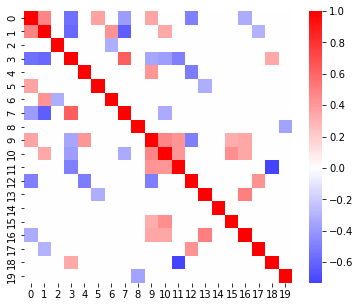

In [338]:
plt.figure(figsize=[6, 5])
mat = np.corrcoef(np.array(cur_res.CPDresult_ctrl[0].T))
mat[np.abs(mat)<0.3] = 0
sns.heatmap(mat, cmap="bwr", center=0)

<AxesSubplot:>

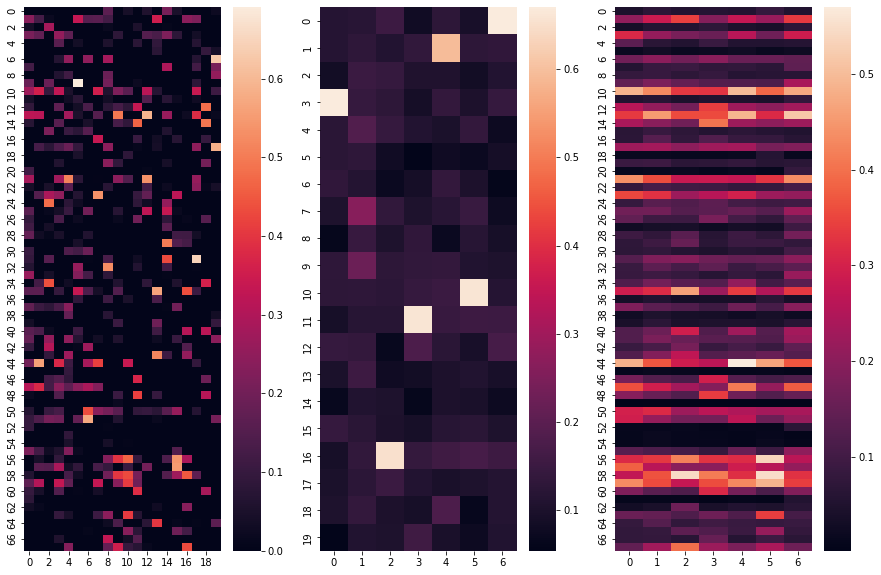

In [323]:
plt.figure(figsize=[15, 10])
plt.subplot(131)
Us = cur_res.CPDresult_ctrl[0]
sns.heatmap(np.abs(Us))
plt.subplot(132)
sns.heatmap(clu_ws.T)
plt.subplot(133)
sns.heatmap(np.abs(cens_wU))

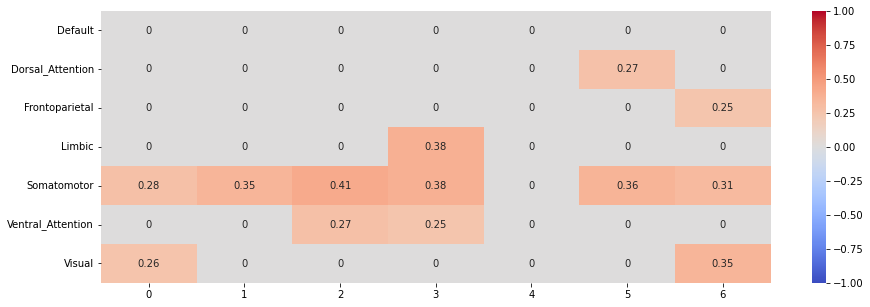

In [117]:
tfn1 = partial(_cumsum_trunc, cutoff=0.8)
_corr_plot(cens_wU, trun_fn=tfn1);

In [118]:
tfn1 = partial(_cumsum_trunc, cutoff=0.8)
trans_fn = lambda x: _minmax_wo0(tfn1(x))
_save_brainplotting_vec(cens_wU, f"clu_ws_{n_clus}", False, trans_fn)
_save_brainplotting_vec(np.abs(cens_wU), f"clu_abs_wU_{n_clus}", False, trans_fn)

### clustering both grps together

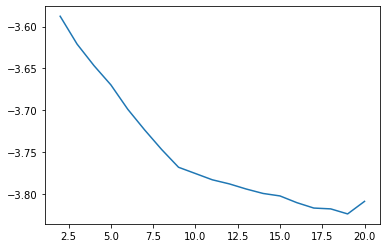

In [202]:
# tuning num of clus (not used)
n_cluss = np.array(list(range(2,21)))
BICs =[]
stds = []
for ix in n_cluss:
    cur_clus = KMeans(n_clusters=ix, random_state=0).fit(singular_vals_both_pool_mm.T)
    BICs.append(kmeans_BIC(cur_clus, 2))
    stds.append(np.std(np.unique(cur_clus.labels_, return_counts=True)[1]))
plt.plot(n_cluss, BICs)

In [315]:
n_clus = 10
clus = SpectralClustering(n_clusters=n_clus, random_state=0).fit(singular_vals_both_pool_mm.T)
#clus = KMeans(n_clusters=n_clus, random_state=0).fit(singular_vals_both_pool_mm.T)
both_labs = clus.labels_
np.unique(clus.labels_, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([ 87,  79,  83,  87, 110, 112, 120, 231, 108, 196]))

In [316]:
clu_Ys = np.array(["AD"]*len(singular_vals_ADs_pool.T) + ["ctrl"]*len(singular_vals_ctrls_pool.T))
ct_table = pd.crosstab(both_labs, clu_Ys)
ct_table

col_0,AD,ctrl
row_0,,
0,35,52
1,18,61
2,29,54
3,30,57
4,45,65
5,26,86
6,43,77
7,71,160
8,48,60


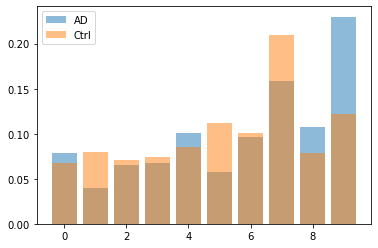

In [317]:
AD_ratios = np.array(ct_table["AD"])/singular_vals_ADs_pool.shape[-1]
ctrl_ratios = np.array(ct_table["ctrl"])/singular_vals_ctrls_pool.shape[-1]
plt.bar(np.arange(0, n_clus), AD_ratios, alpha=0.5, label="AD")
plt.bar(np.arange(0, n_clus), ctrl_ratios, alpha=0.5, label="Ctrl")
plt.legend()

In [282]:
AD_clu_idxs = [5, 8, 9]
ctrl_clu_idxs = [0, 6, 12]

AD_ws = []
for clu_idx in AD_clu_idxs:
    kpidx = np.bitwise_and(clu_Ys=="AD", both_labs==clu_idx)
    #kpidx = both_labs==clu_idx
    cur_w = singular_vals_both_pool_mm[:, kpidx].mean(axis=1)
    #cur_w = _cumsum_trunc(cur_w, 0.8)
    AD_ws.append(cur_w)
    
AD_ws = np.array(AD_ws)
AD_wUs = np.matmul(cur_res.CPDresult_ctrl[0], AD_ws.T)

ctrl_ws = []
for clu_idx in ctrl_clu_idxs:
    kpidx = np.bitwise_and(clu_Ys=="ctrl", both_labs==clu_idx)
    #kpidx = both_labs==clu_idx
    cur_w = singular_vals_both_pool_mm[:, kpidx].mean(axis=1)
    #cur_w = _cumsum_trunc(cur_w, 0.8)
    ctrl_ws.append(cur_w)
    
ctrl_ws = np.array(ctrl_ws)
ctrl_wUs = np.matmul(cur_res.CPDresult_ctrl[0], ctrl_ws.T)

<AxesSubplot:>

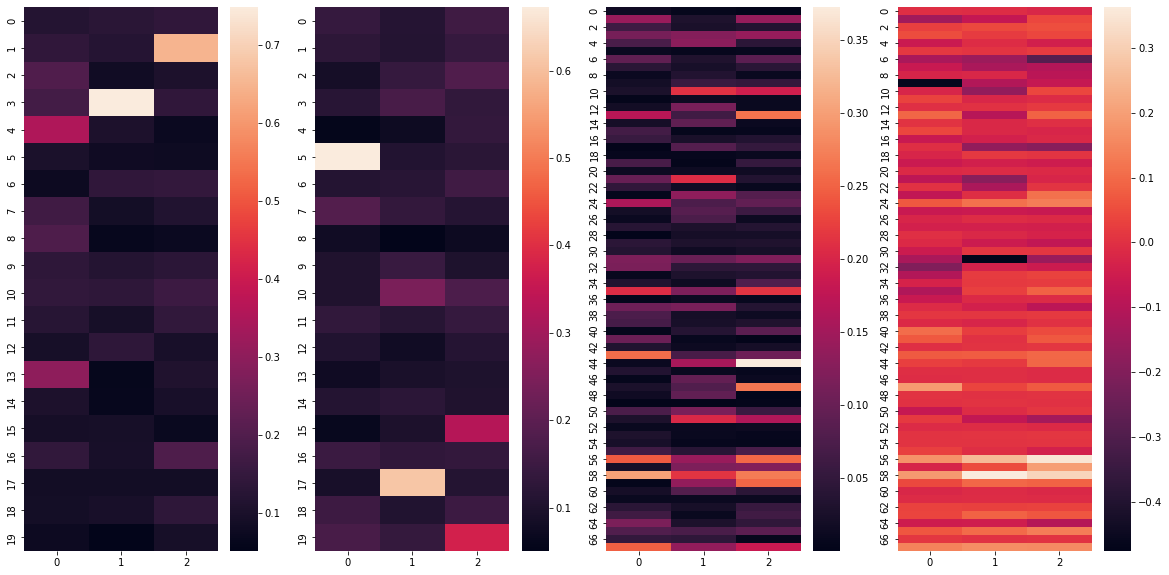

In [284]:
plt.figure(figsize=[20, 10])

plt.subplot(141)
sns.heatmap(ctrl_ws.T)
plt.subplot(142)
sns.heatmap(AD_ws.T)

plt.subplot(143)
sns.heatmap(np.abs(ctrl_wUs))
plt.subplot(144)
sns.heatmap(np.abs(AD_wUs))

In [286]:
AD_wUs[56, :] = 0
AD_wUs[58, :] = 0
tfn1 = partial(_cumsum_trunc, cutoff=0.8)
trans_fn = lambda x: _minmax_wo0(tfn1(x))
_save_brainplotting_vec(AD_wUs, f"AD_wU", False, trans_fn)
_save_brainplotting_vec(np.abs(AD_wUs), f"AD_abs_wU", False, trans_fn)

In [287]:
ctrl_wUs[56, :] = 0
ctrl_wUs[58, :] = 0
tfn1 = partial(_cumsum_trunc, cutoff=0.8)
trans_fn = lambda x: _minmax_wo0(tfn1(x))
_save_brainplotting_vec(ctrl_wUs, f"ctrl_wU", False, trans_fn)
_save_brainplotting_vec(np.abs(ctrl_wUs), f"ctrl_abs_wU", False, trans_fn)

### Transition

In [50]:
flag = 0
AD_clu_labs = []
for cur_v in singular_vals_ADs:
    n_ele = cur_v.shape[1]
    AD_clu_labs.append(AD_labs[flag:(flag+n_ele)])
    flag += n_ele
    
flag = 0
ctrl_clu_labs = []
for cur_v in singular_vals_ctrls:
    n_ele = cur_v.shape[1]
    ctrl_clu_labs.append(ctrl_labs[flag:(flag+n_ele)])
    flag += n_ele

In [51]:
trans_ct = edict()

cur_trans_ct = np.zeros((n_clus, n_clus))
for ix in range(len(AD_clu_labs)):
    cur_vec = AD_clu_labs[ix]
    cur_trans_ct = update_trans_ct(cur_trans_ct, cur_vec)
trans_ct.AD = cur_trans_ct

cur_trans_ct = np.zeros((n_clus, n_clus))
for ix in range(len(ctrl_clu_labs)):
    cur_vec = ctrl_clu_labs[ix]
    cur_trans_ct = update_trans_ct(cur_trans_ct, cur_vec)
trans_ct.ctrl = cur_trans_ct

In [52]:
non_diag_mask = ~np.eye(n_clus,dtype=bool)

In [53]:
def mat_2df(mat, include_diag=False, no_zero=True, cut_off=None):
    source = np.repeat(list(range(1, 1+n_clus)), n_clus)
    target = np.repeat(np.arange(1,1+n_clus).reshape(1,-1), n_clus, axis=0).reshape(-1)
    value = mat.flatten()
    idxs = source !=-100
    if not include_diag:
        idxs = np.bitwise_and(idxs, source != target)
    if no_zero:
        idxs = np.bitwise_and(idxs, value!=0)
    if cut_off is not None:
        idxs = np.bitwise_and(idxs, value>cut_off)
    source = source[idxs]
    target = target[idxs]
    value = value[idxs]
    res_df = pd.DataFrame({
        "source": source, 
        "target": target, 
        "value": value.astype(int)
    })
    return res_df

In [57]:
nodes = pd.DataFrame({
    "index": list(range(1, n_clus+1)),
    "name": [f"State {ix}" for ix in range(1, n_clus+1)]
})
nodes = hv.Dataset(nodes, "index")

cut_v = np.median(np.concatenate([trans_ct.AD[non_diag_mask], trans_ct.ctrl[non_diag_mask]]))

:Chord   [source,target]   (value)
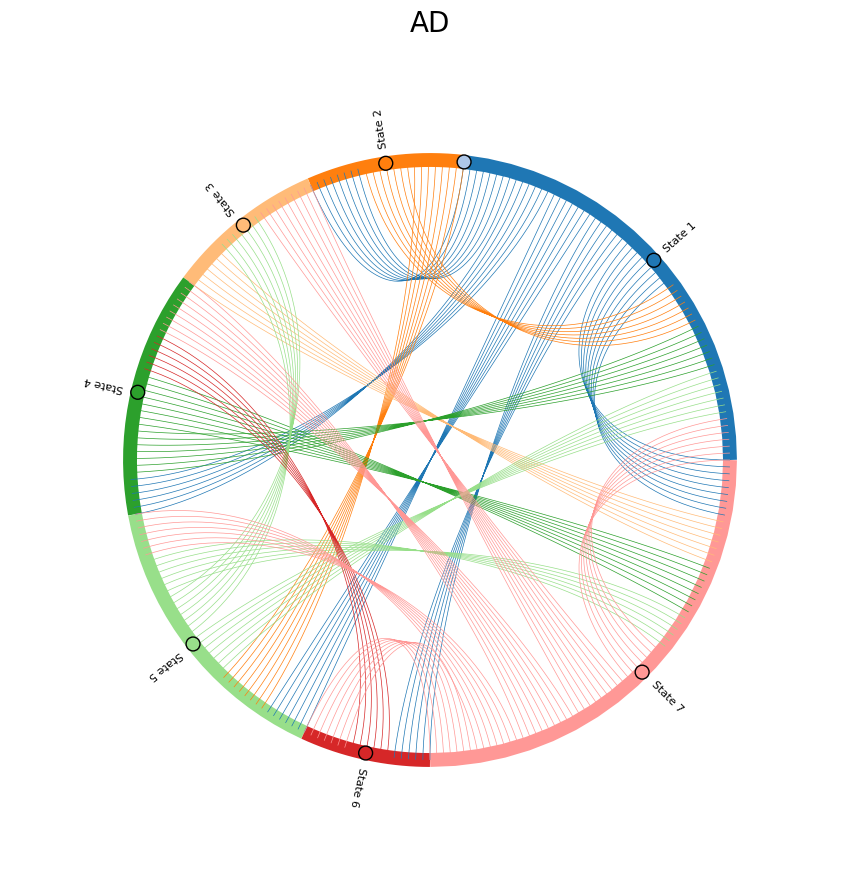

In [58]:
plt_data_AD = mat_2df(trans_ct.AD, False, cut_off=cut_v)

chord = hv.Chord((plt_data_AD, nodes))
chord.opts(cmap='Category20', labels='name', 
           title="AD", fontsize=20, 
           zrotation=45,
           edge_color=dim('source').str(), 
           node_color=dim("index").str())

:Chord   [source,target]   (value)
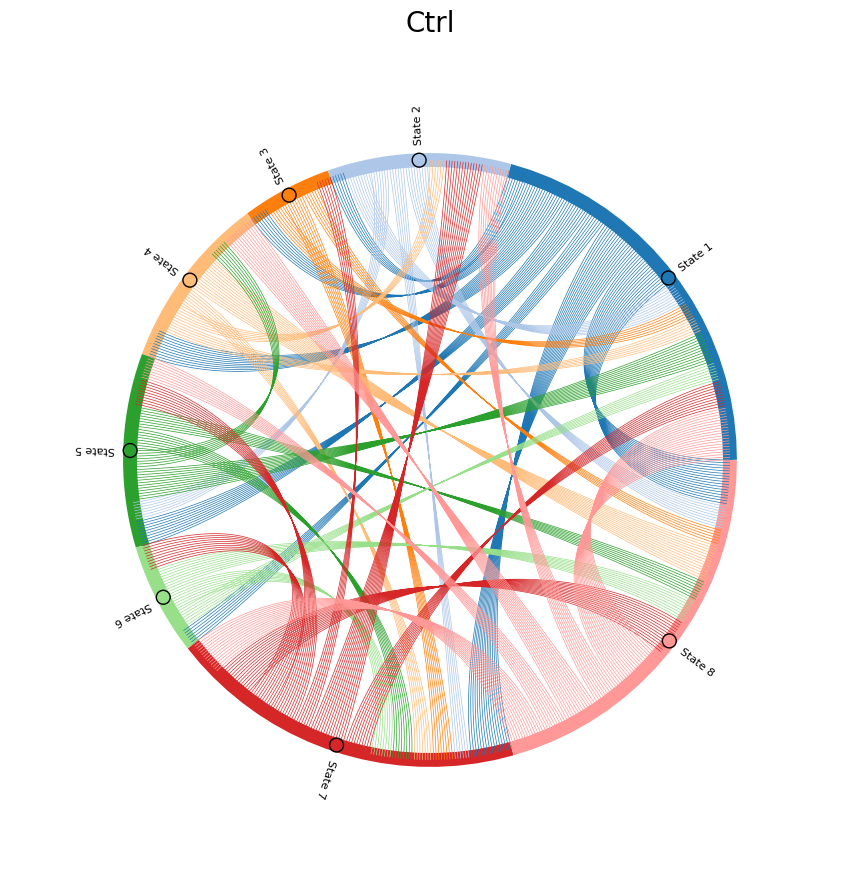

In [59]:
plt_data_ctrl = mat_2df(trans_ct.ctrl, False, cut_off=cut_v)

chord = hv.Chord((plt_data_ctrl, nodes))
chord.opts(cmap='Category20', labels='name', 
           title="Ctrl", fontsize=20, 
           edge_color=dim('source').str(), 
           node_color=dim("index").str())

### Dwell x wU

#### Each segment

In [60]:
dwells_AD = [cpts_2dwells(cpts) for cpts in cpts_ADs_selected]
dwells_ctrl = [cpts_2dwells(cpts) for cpts in cpts_ctrls_selected]

In [61]:
dwells_sigvec_AD = ddict(list)
for ix in range(len(singular_vals_ADs)):
    cur_dwells = dwells_AD[ix]
    cur_idxs = AD_clu_labs[ix] +1 # adjust such that starting from 1 (not 0)
    [dwells_sigvec_AD[cur_idxs[ix]].append(cur_dwells[ix]) for ix in range(len(cur_idxs))]
    
dwells_sigvec_ctrl = ddict(list)
for ix in range(len(singular_vals_ctrls)):
    cur_dwells = dwells_ctrl[ix]
    cur_idxs = ctrl_clu_labs[ix] +1 # adjust such that starting from 1 (not 0)
    [dwells_sigvec_ctrl[cur_idxs[ix]].append(cur_dwells[ix]) for ix in range(len(cur_idxs))]

In [62]:
sum_dwells = edict()
sum_dwells.AD = list()
sum_dwells.ctrl = list()

for ix in range(1, n_clus+1):
    sum_dwells.AD.append(np.sum(dwells_sigvec_AD[ix]))
    sum_dwells.ctrl.append(np.sum(dwells_sigvec_ctrl[ix]))

In [63]:
for ix in range(1, 9):
    print(scipy.stats.ttest_ind(dwells_sigvec_AD[ix], dwells_sigvec_ctrl[ix]))

Ttest_indResult(statistic=3.8299406845260613, pvalue=0.00016569257000307892)
Ttest_indResult(statistic=2.4514155524940606, pvalue=0.016018806896922325)
Ttest_indResult(statistic=1.2178263679305452, pvalue=0.2264041725079676)
Ttest_indResult(statistic=1.903821736688248, pvalue=0.059000264871452705)
Ttest_indResult(statistic=1.38164810104554, pvalue=0.16932876471125685)
Ttest_indResult(statistic=2.390608549809347, pvalue=0.018402498828867304)
Ttest_indResult(statistic=5.2162101463395025, pvalue=4.840502764428226e-07)
Ttest_indResult(statistic=3.656036985717152, pvalue=0.00032305399207025674)


In [64]:
ratio_dwells = edict()
for type_ in ["AD", "ctrl"]:
    ratio_dwells[type_] = np.array(sum_dwells[type_])/np.sum(sum_dwells[type_])

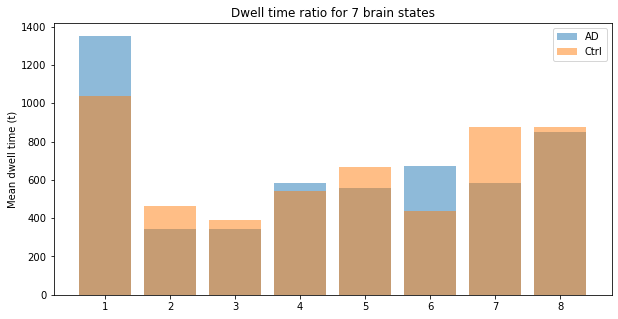

In [65]:
plt.figure(figsize=[10, 5])
plt.bar(list(range(1, n_clus+1)), sum_dwells["AD"], alpha=0.5, label="AD")
plt.bar(list(range(1, n_clus+1)), sum_dwells["ctrl"], alpha=0.5, label="Ctrl")
plt.title("Dwell time ratio for 7 brain states")
plt.ylabel("Mean dwell time (t)")
#plt.xticks(np.array(list(range(0, n_clus)))+0.5, states, rotation=45)
plt.legend()

####  each subject

In [66]:
# dwell time of each states for each subject
dwells_sigvec_AD_sub = []
for ix in range(len(singular_vals_ADs)):
    cur_dwells = dwells_AD[ix]
    cur_idxs = AD_clu_labs[ix] # adjust such that starting from 0 (not 1)
    dwells_sigvec_AD_sub.append([np.sum(cur_dwells[cur_idxs==iy]) for iy in range(n_clus)])
    
dwells_sigvec_ctrl_sub = []
for ix in range(len(singular_vals_ctrls)):
    cur_dwells = dwells_ctrl[ix]
    cur_idxs = ctrl_clu_labs[ix] # adjust such that starting from 0 (not 1)
    dwells_sigvec_ctrl_sub.append([np.sum(cur_dwells[cur_idxs==iy]) for iy in range(n_clus)])
    
dwells_sigvec_AD_sub = np.array(dwells_sigvec_AD_sub)
dwells_sigvec_ctrl_sub = np.array(dwells_sigvec_ctrl_sub)

In [67]:
dwells_subs = np.concatenate([dwells_sigvec_AD_sub, dwells_sigvec_ctrl_sub], axis=0)
dwells_subs_df = {f"State{ix+1}":dwells_subs[:, ix] for ix in range(n_clus)}
dwells_subs_df["group"] = ["AD"]*88 + ["ctrl"] * 88
dwells_subs_df = pd.DataFrame(dwells_subs_df)

In [68]:
dwells_subs_df.groupby("group").mean()

,State1,State2,State3,State4,State5,State6,State7,State8
group,,,,,,,,
AD,15.351231,3.896402,3.920360,6.611174,6.312121,7.648011,6.604545,9.656155
ctrl,11.781155,5.242140,4.433333,6.167235,7.569981,4.944129,9.928788,9.933239


In [69]:
for ix in range(n_clus):
    test_res = scipy.stats.ranksums(dwells_sigvec_AD_sub[:, ix], 
                                     dwells_sigvec_ctrl_sub[:, ix])
    print(test_res)

RanksumsResult(statistic=-0.2988427274787093, pvalue=0.765060047955801)
RanksumsResult(statistic=-2.3759476254000353, pvalue=0.01750394714530497)
RanksumsResult(statistic=-0.6050825521722382, pvalue=0.5451241467277258)
RanksumsResult(statistic=-0.3742931190698686, pvalue=0.708186250844475)
RanksumsResult(statistic=-0.9527461212687565, pvalue=0.3407187189388875)
RanksumsResult(statistic=0.6361503604744803, pvalue=0.5246784238995966)
RanksumsResult(statistic=-2.3300856226681543, pvalue=0.0198016261573193)
RanksumsResult(statistic=-1.3802983402853257, pvalue=0.1674948057865996)


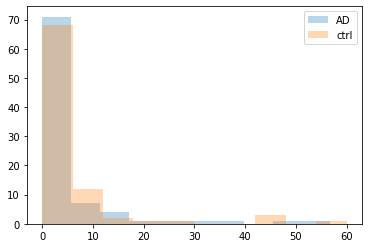

In [70]:
ix = 2
plt.hist(dwells_sigvec_AD_sub[:, ix], label="AD", alpha=0.3)
plt.hist(dwells_sigvec_ctrl_sub[:, ix], label="ctrl", alpha=0.3)
plt.legend()